## Facebook Prophet

In [4]:
import pandas as pd
import os
from scipy.io import arff
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import logging
from pandas import read_csv
from pandas import DataFrame
from prophet import Prophet
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

In [5]:
import time
start_time = time.time()

In [8]:
def Prophet3SA(data_csv,training_ratio):
    # # load a dataset
    # data_file =f'WekaData/{data_csv}.arff'
    # print(data_file)
    # # Load arff file
    # data, meta = arff.loadarff(data_file)
    # data_df = pd.DataFrame(data)
    data_df=pd.read_csv(f'../Data/{data_csv}.csv')
   
    # Convert to pandas DataFrame
    #data_df = pd.read_csv('bitcoin_hist.csv')
    #data_df["Date"] =  pd.to_datetime(data_df["Date"], format="%m/%d/%Y")

    data_df.plot(x='Date', y=['Close', 'Volume'], style=['r-', 'g-'], figsize=(10, 6), linewidth=1)  # for stock

    # define the date format
    date_form = mdates.DateFormatter('%Y')

    # set the x-axis major locator to every even year
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(date_form)
    ax.set_yscale("log")
    fig_name="figure/Close&Volume "+data_csv+str(training_ratio)+".png"
    plt.savefig(fig_name)



    # evaluate prophet time series forecasting model on hold out dataset    
    # preparing the data
    df = data_df[['Date', 'Close', 'High', 'Low']].rename(columns={
        'Date':'ds', 'Close':'y', 'High': 'cap', 'Low': 'flr'})

    # Assuming df is your DataFrame containing a 'y' column
    df['y_1_step_ago'] = df['y'].shift(1)
    df['y_2_steps_ago'] = df['y'].shift(2)
    df['y_3_steps_ago'] = df['y'].shift(3)

    # You may want to drop the rows where the new columns are NaN, which will be the case for the first few rows
    df = df.dropna()

    # because it's multiplicative, so apply np.log
    #dataset = np.log(dataset)

    # Initialize a scaler for the dataset
    #scaler = MinMaxScaler(feature_range=(0, 1))
    # Z-score normalization is useful when the data has outliers or when the distribution of the data is not known. 
    #scaler = StandardScaler() 

    # Fit and transform the data to the scaler
    # Split into train and test sets
    if training_ratio<1:training_ratio=1-training_ratio
    else: training_ratio=df.shape[0]-7
    
    train_data, test_data = train_test_split(df, train_size=training_ratio, shuffle=False)

    # Fit the scaler to the training data and transform the training data
    #train = scaler.fit_transform(train_data)
    train_df = train_data.copy()
    # Use the same scaler to transform the test data
    #test = scaler.transform(test_data)
    test_df = test_data.copy()
    print(train_df.shape, test_df.shape)### Using Multiple Layer Perceptron
    
    # Finding better parameters for Prophet
    param_grid = {
    'seasonality_mode': ('additive', 'multiplicative'),
    'changepoint_prior_scale': [0.1, 0.5, 1.0],    
    }   

    fourier_grid = {
        'name': ['myweek'], 
        'period': [12+12*i for i in range(10)],
        'fourier_order': [5+5*i for i in range(10)]
    }



    for logger_name in logging.root.manager.loggerDict:
        if 'cmdstanpy' in logger_name:
            logging.getLogger(logger_name).setLevel(logging.WARNING)

    # Split data into training and validation sets
    ntrain_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=False)

    best_params = None
    lowest_rmse = float('inf')

    # Iterate over all possible combinations of parameters
    #for params in ParameterGrid(param_grid):
    for fourier in ParameterGrid(fourier_grid):
            model = Prophet() #**params)
            model.add_seasonality(**fourier)
            model.add_regressor('y_1_step_ago')
            model.add_regressor('y_2_steps_ago')
            model.add_regressor('y_3_steps_ago')
            model.fit(ntrain_df)
            forecast = model.predict(val_df)
        
            # Compute the error metric of your choice (e.g., RMSE)
            mse = mean_squared_error(val_df['y'], forecast['yhat'])
            rmse = math.sqrt(mse)

            if rmse < lowest_rmse:
                lowest_rmse = rmse
                #best_params = params
                best_fourier = fourier
                print(f'current lowest rmse: {rmse}')

    print(f'Best params: {best_fourier}')


    # define the model
    model = Prophet()#**best_params)
    model.add_regressor('y_1_step_ago')
    model.add_regressor('y_2_steps_ago')
    model.add_regressor('y_3_steps_ago')
    model.add_seasonality(**best_fourier)
    # fit the model
    model.fit(train_df)

    # use the model to make a forecast
    train_forecast = model.predict(train_df)
    # calculate MAE between expected and predicted values for december
    train_y_true = train_df['y'].values
    train_y_pred = train_forecast['yhat'].values
    train_mse = mean_squared_error(train_y_true, train_y_pred)
    train_mae = mean_absolute_error(train_y_true, train_y_pred)
    print(f'prophet_train MSE: {train_mse:.4f}, RMSE: {math.sqrt(train_mse):.4f}, MAE: {train_mae:.4f}')

    test_forecast = model.predict(test_df)

    # calculate MAE between expected and predicted values for december
    test_y_true = test_df['y'].values
    test_y_pred = test_forecast['yhat'].values
    test_mse = mean_squared_error(test_y_true, test_y_pred)
    test_mae = mean_absolute_error(test_y_true, test_y_pred)
    print(f'test MSE: {test_mse:.4f}, RMSE: {math.sqrt(test_mse):.4f}, MAE: {test_mae:.4f}')



    plt.figure(figsize=(12, 6))

    # # Plotting the true values for the training set
    # plt.plot(train_df['ds'], train_df['y'], label='True Training Values')

    # # Plotting the predicted values for the training set
    # plt.plot(train_df['ds'], train_forecast['yhat'], label='Predicted Training Values')

    # Plotting the true values for the test set
    plt.plot(test_df['ds'], test_df['y'], label='True Test Values')

    # Plotting the predicted values for the test set
    plt.plot(test_df['ds'], test_forecast['yhat'], label='Predicted Test Values')

    plt.title('Bitcoin Close Price Forecast (Training & Test Sets)')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.savefig("figure/Price_Forecast "+data_csv+str(training_ratio)+".png")

    from prophet.plot import plot_components
    #plot_components(model, train_forecast)
    plot_components(model, test_forecast).savefig("figure/Plot_Components "+data_csv+str(training_ratio)+".png")
    return math.sqrt(train_mse),train_mae,math.sqrt(test_mse),test_mae,best_fourier


(6650, 7) (2850, 7)
current lowest rmse: 153.52493021675832
current lowest rmse: 153.36241030878685
current lowest rmse: 153.1061847169152
current lowest rmse: 151.89619329417573
Best params: {'fourier_order': 5, 'name': 'myweek', 'period': 72}
prophet_train MSE: 14654.3757, RMSE: 121.0553, MAE: 70.4474
test MSE: 23956.9092, RMSE: 154.7802, MAE: 119.0188
(6650, 7) (2850, 7)
current lowest rmse: 11.26104009268787
current lowest rmse: 11.18641698232763
current lowest rmse: 11.12787061043716
Best params: {'fourier_order': 5, 'name': 'myweek', 'period': 72}
prophet_train MSE: 113.7164, RMSE: 10.6638, MAE: 6.5244
test MSE: 74.8745, RMSE: 8.6530, MAE: 5.9108


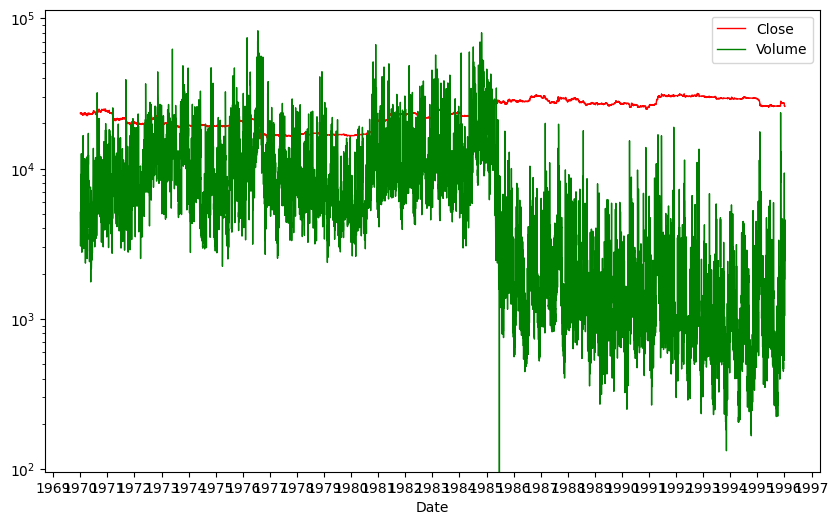

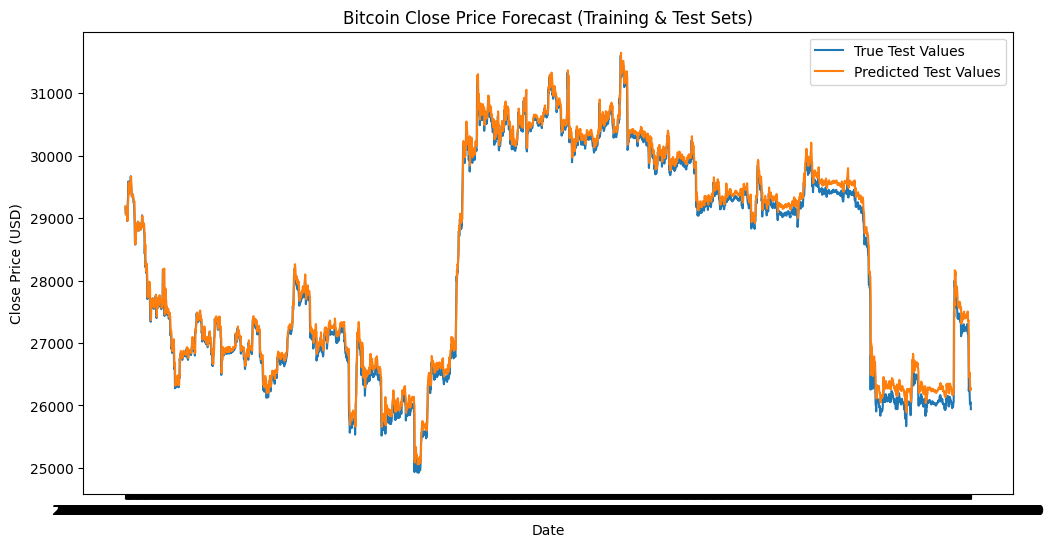

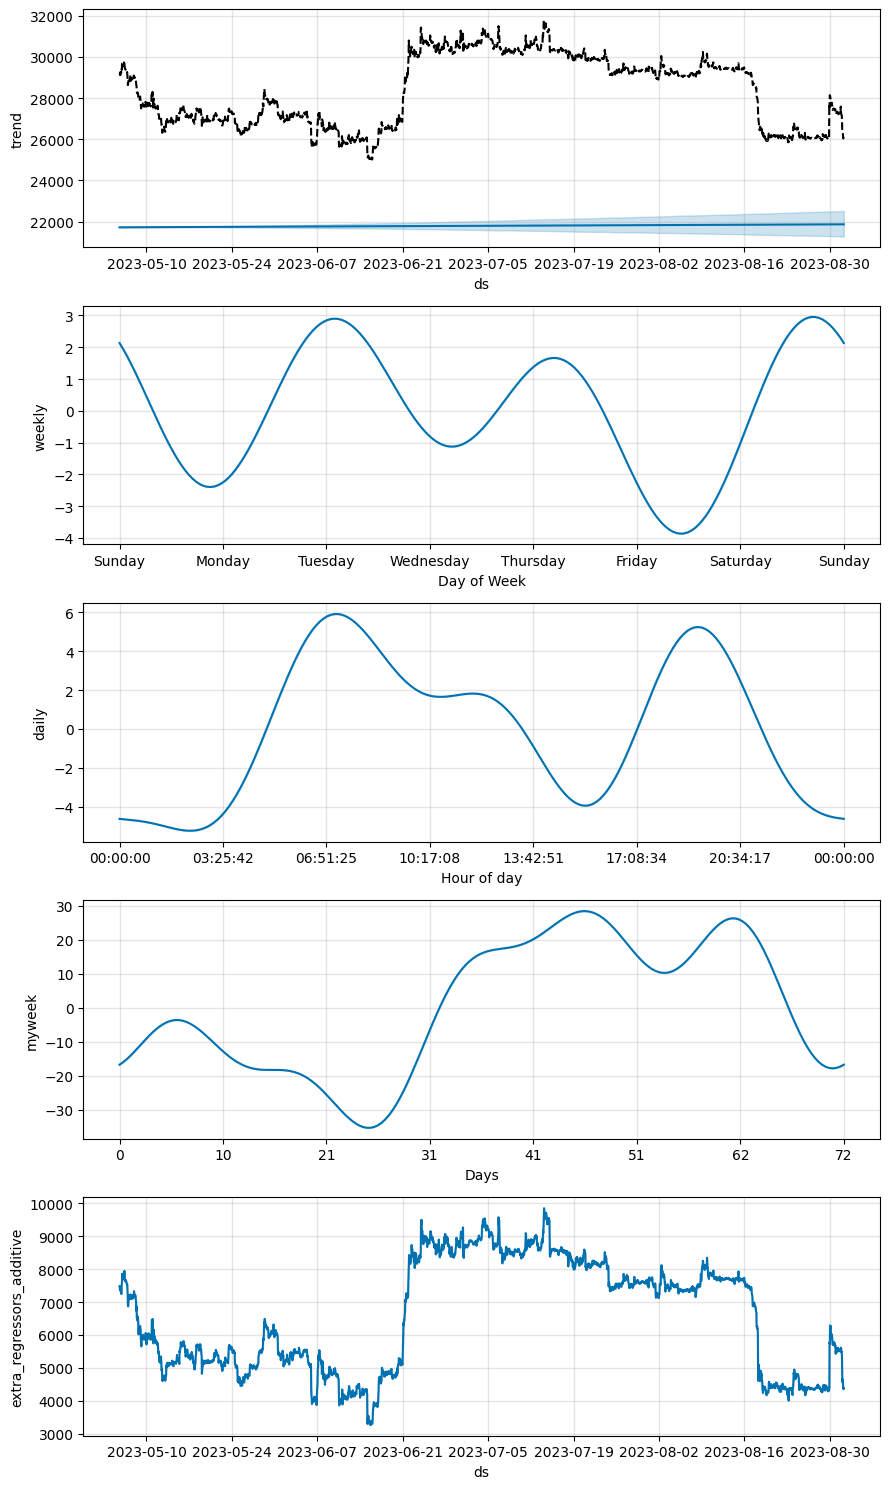

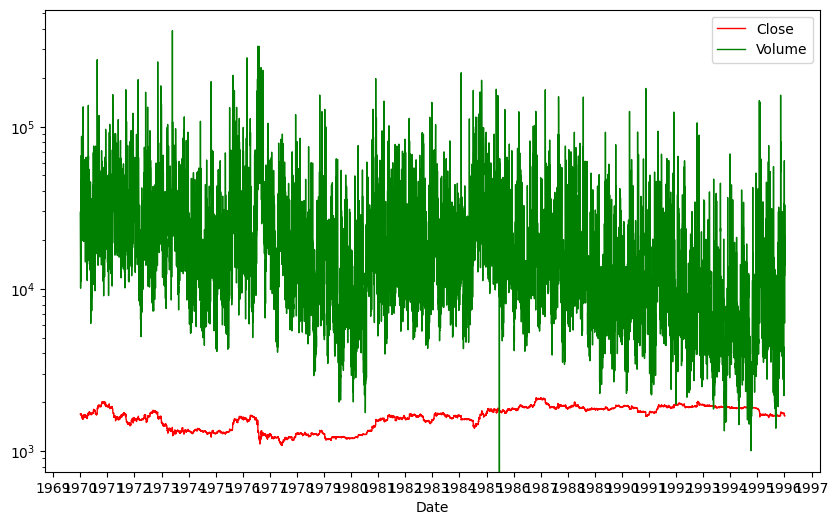

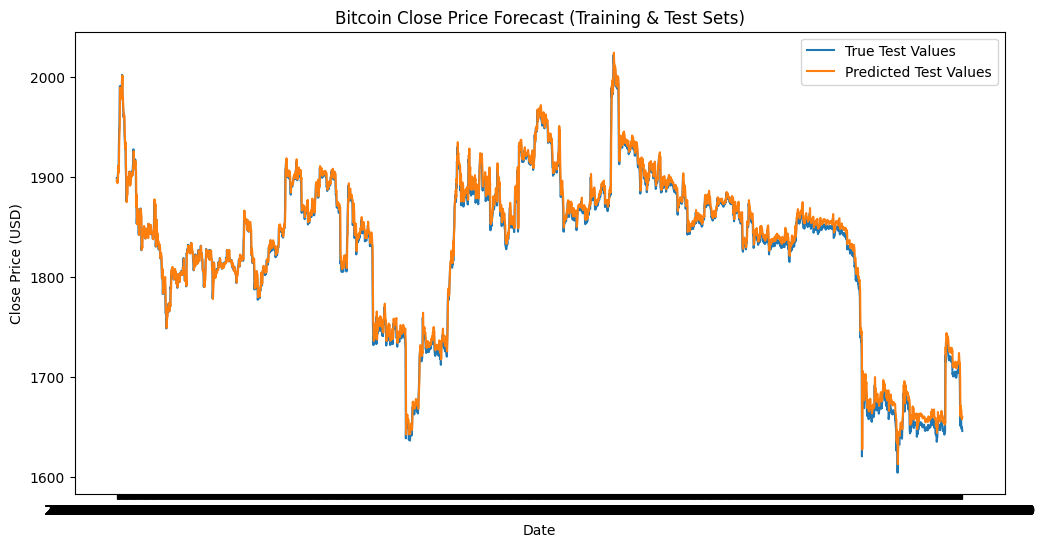

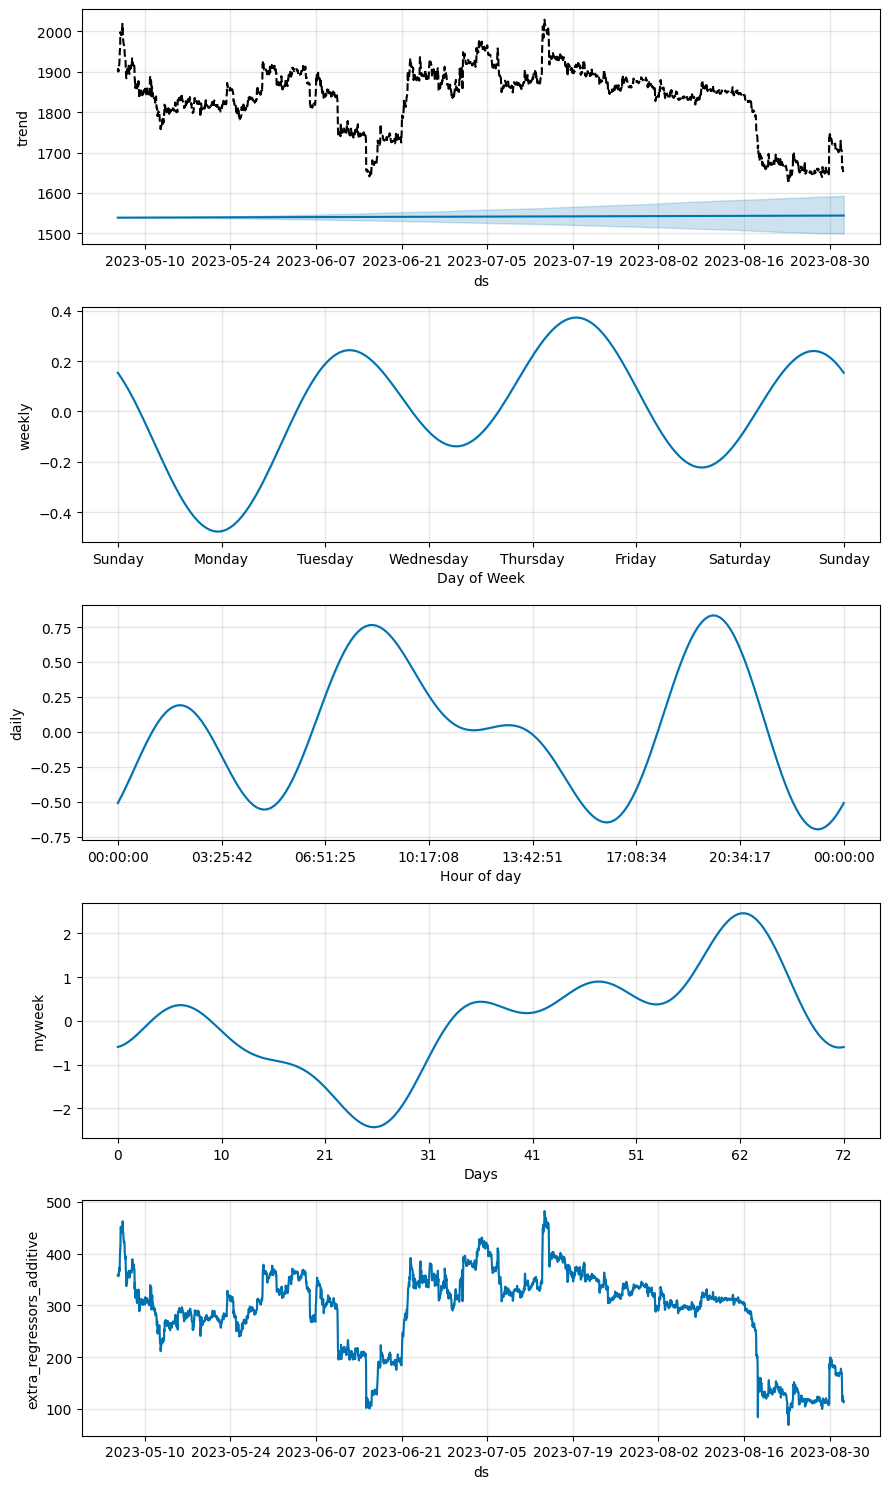

In [9]:
import pandas as pd
# file_list=['BTC-all','BTCUSDT-1h','ETH-all','ETHUSDT-1h']
Arff_list=['BTCUSDT-1h','ETHUSDT-1h']
Split_list=[0.3]

Arff=list()
Classifiers_list=list()
Split=list()

train_mae=list()
train_rmse=list()

test_mae=list()
test_rmse=list()
best_fouriers=list()



for arffs in Arff_list:
    for split in Split_list:
        Arff.append(arffs)
        Classifiers_list.append('Prophet')
        Split.append(split)
        
        Result=Prophet3SA(arffs,split)
        train_mae.append(Result[1])
        
        train_rmse.append(Result[0])
        test_mae.append(Result[3])
       
        test_rmse.append(Result[2])
        best_fouriers.append(Result[4])



Summary={'Data':Arff,'Classifier':Classifiers_list,'Test Split':Split,
            'train_mae':train_mae,
            'train_rmse':train_rmse,
            'test_mae':test_mae,
            'test_rmse':test_rmse,
            'best_fouriers':best_fouriers
         }

df_Summary = pd.DataFrame(Summary)
df_Summary.to_excel("Summary-Prophet-1H.xlsx")
